In [1]:
import os
from Bio import SeqIO

In [2]:
def ucitaj_genome(putanja_do_foldera):
    genomi = {}
    for ime_fajla in os.listdir(putanja_do_foldera): 
        if ime_fajla.endswith(".fasta"):
            putanja_do_fajla = os.path.join(putanja_do_foldera, ime_fajla)
            with open(putanja_do_fajla, "r") as fajl:
                virus = ime_fajla[:-6]
                for genom in SeqIO.parse(fajl, "fasta"):
                    genomi[virus] = genom.seq

    return genomi

In [3]:
putanja_do_foldera = 'podaci/genomi'
genomi = ucitaj_genome(putanja_do_foldera)

In [4]:
with open('podaci/proteini/kodoni.fasta', 'r') as f:
    i = 0
    proteini = []
    for line in f.readlines():
        if i % 3 == 0:
            linija = line.split(' | ')
            virus = linija[0][1:]
            naziv = linija[1][:-1]
        if i % 3 == 1:
            protein = line[:-1]
        if i % 3 == 2:
            proteini.append((virus, naziv, protein))
        i += 1

In [9]:
mers = 0
sars = 0
for i in range(len(proteini)):
    if proteini[i][0] == 'mers':
        mers += 1
    if proteini[i][0] == 'sars1':
        sars += 1

In [10]:
print(mers)

11


In [11]:
print(sars)

15


In [54]:
import numpy as np
def hamingovo_rastojanje(a, b): #a i b su sekvence kodona ili aminokiselina
    haming = 0
    i = 0
    
    a = np.array(list(a))
    b = np.array(list(b))
    
    for x, y in zip(a, b):
        if str(x) == str(y):
            haming += 0
        else:
            haming += 1
        i += 1
    return haming

In [55]:
def edit_rastojanje(str1, str2):
    len_str1 = len(str1)
    len_str2 = len(str2)
    
    # Inicijalizujemo matricu za čuvanje rastojanja
    distance = [[0] * (len_str2 + 1) for _ in range(len_str1 + 1)]
    
    # Inicijalizujemo prvi red i prvu kolonu
    for i in range(len_str1 + 1):
        distance[i][0] = i
    for j in range(len_str2 + 1):
        distance[0][j] = j
    
    # Popunjavamo matricu rastojanja
    for i in range(1, len_str1 + 1):
        for j in range(1, len_str2 + 1):
            if str1[i - 1] == str2[j - 1]:
                cost = 0
            else:
                cost = 1
            distance[i][j] = min(distance[i - 1][j] + 1,        # brisanje
                                 distance[i][j - 1] + 1,        # ubacivanje
                                 distance[i - 1][j - 1] + cost) # zamena
    
    return distance[len_str1][len_str2]

In [56]:
from Bio import pairwise2
from Bio.pairwise2 import align
def edit_rastojanje2(seq1, seq2):
    alignment = pairwise2.align.globalms(seq1, seq2, 2, -1, -0.5, -0.1)[0]
    return alignment.score

In [57]:
edit_rastojanje(proteini[1][2], proteini[2][2])

3750

In [58]:
len(proteini[0][2])

13173

In [59]:
edit_rastojanje2(proteini[1][2], proteini[2][2])

217.0000000000111

In [60]:
edit_rastojanje(proteini[0][2], proteini[1][2])

9168

In [61]:
edit_rastojanje2(proteini[0][2], proteini[1][2])

6352.499999999376

In [62]:
proteini[1][1]

'spike protein [Middle East respiratory syndrome-related coronavirus]'

In [63]:
def izracunaj_edit_rastojanja():
    izracunata_rastojanja = {}
    edit_rastojanja = {}
    imena = []
    
    for protein1 in proteini:
        for protein2 in proteini:
            ime1 = protein1[0] + ' | ' + protein1[1]
            ime2 = protein2[0] + ' | ' + protein2[1]
            if ime1 not in imena:
                imena.append(ime1)
            if ime2 not in imena:
                imena.append(ime2)
            
            if protein1 == protein2:
                edit_rastojanja[(ime1, ime2)] = 0
                continue
                
            if (ime1, ime2) in izracunata_rastojanja:
                edit_rastojanja[(ime2, ime1)] = izracunata_rastojanja[(ime1, ime2)]
                continue
            else:
                edit_rastojanja[(ime1, ime2)] =  hamingovo_rastojanje(protein1[2], protein2[2])
                izracunata_rastojanja[(ime1, ime2)] = edit_rastojanja[(ime1, ime2)]
                
    return edit_rastojanja, imena

In [64]:
rastojanja, imena = izracunaj_edit_rastojanja()

In [65]:
rastojanja[(imena[0], imena[1])]

2975

In [66]:
imena_u_brojevima = [i for i in range(len(imena))]

In [67]:
matrica = [[0] * (len(imena) + 1) for _ in range(len(imena) + 1)]

In [68]:
for i in range(len(imena) + 1):
    for j in range(len(imena) + 1):
        if i == 0 and j == 0:
            matrica[i][j] = -1
            continue
        
        if i == 0:    
            matrica[i][j] = imena_u_brojevima[j-1]
        elif j == 0:  
            matrica[i][j] = imena_u_brojevima[i-1]
        else:  
            matrica[i][j] = rastojanja[(imena[i-1],imena[j-1])]

In [69]:
import csv

def save_matrix_to_csv(matrix, file_name):
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(matrix)

In [70]:
save_matrix_to_csv(matrica, 'podaci_za_klasterovanje')

In [71]:
import pandas as pd

In [72]:
dataset = pd.read_csv('podaci_za_klasterovanje')

In [73]:
dataset = dataset.drop(columns=["-1"])

In [74]:
dataset.shape

(56, 56)

In [75]:
from sklearn.cluster import AgglomerativeClustering

In [76]:
X = np.array(dataset)

In [77]:
model = AgglomerativeClustering(n_clusters=5, metric="precomputed", linkage='complete')

In [78]:
klasteri = model.fit_predict(X)

In [79]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,0,2975,232,236,545,496,188,478,947,244,...,9373,595,937,2883,232,176,504,994,124,9389
1,2975,0,220,237,531,463,166,506,891,264,...,2921,597,918,2850,236,178,505,970,136,2921
2,232,220,0,236,230,230,181,227,223,244,...,225,218,218,219,215,188,210,243,127,225
3,236,237,236,0,240,241,181,236,242,246,...,246,231,243,238,238,189,233,238,133,246
4,545,531,230,240,0,486,180,485,525,260,...,521,530,525,538,240,181,498,534,138,521


/tmp/ipykernel_9010/1461438501.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(X, method='centroid')


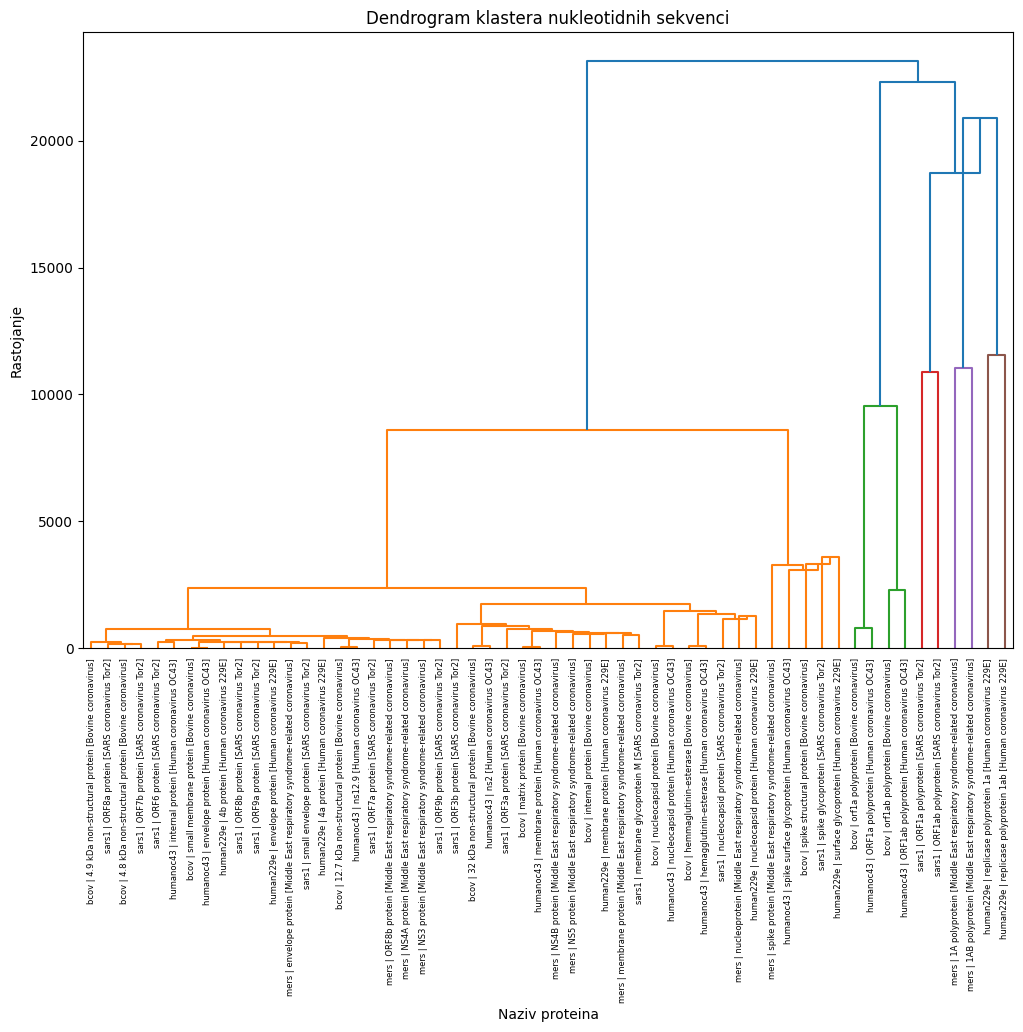

In [80]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Izračunavanje hijerarhijskog klastera
linkage_matrix = linkage(X, method='centroid')

# Iscrtavanje dendrograma
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=imena)
plt.title('Dendrogram klastera nukleotidnih sekvenci')
plt.xlabel('Naziv proteina')
plt.ylabel('Rastojanje')
plt.show()

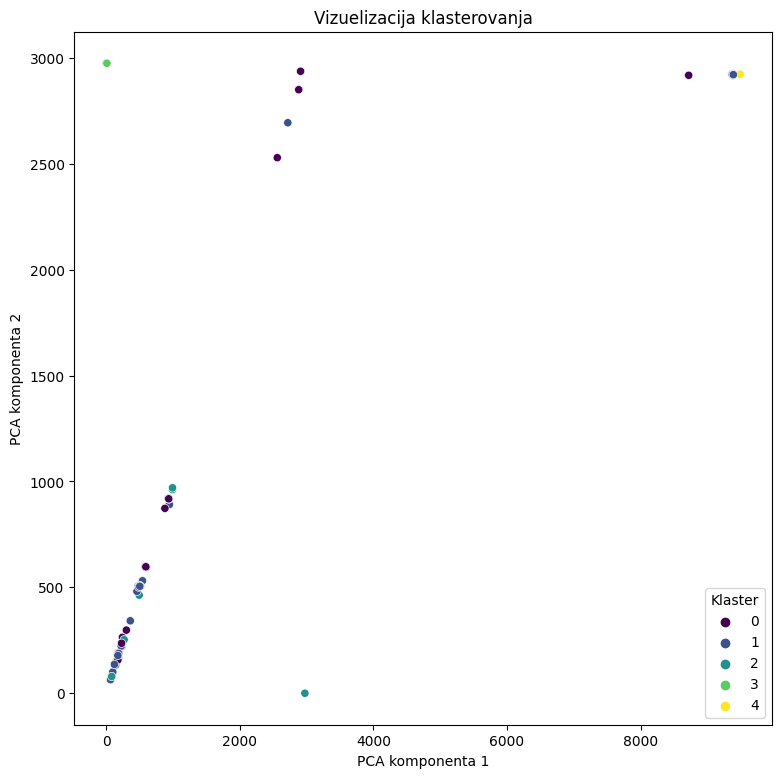

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prvo smanjite dimenzije matrice rastojanja
from sklearn.decomposition import PCA

plt.figure(figsize=(9, 9))

# Izdvojte x i y koordinate
x = X[:, 0]
y = X[:, 1]

# Plotujte scatter plot
sns.scatterplot(x=x, y=y, hue=klasteri, palette='viridis')
plt.title('Vizuelizacija klasterovanja')
plt.xlabel('PCA komponenta 1')
plt.ylabel('PCA komponenta 2')
plt.legend(title='Klaster')
plt.show()

In [82]:
suma = 0
for i in range(56):
    suma += i

In [83]:
suma*30/60/60*0.5*3/2

9.625

In [ ]:
import numpy as np
import time

In [ ]:
def ucitaj_proteine(putanja_do_fajla):
    proteini_rnk = {}
    with open(putanja_do_fajla, "r") as fajl:
        for red in SeqIO.parse(fajl, "fasta"):
            proteini_rnk[red.description] = red.seq

    return proteini_rnk

putanja_do_fajla = "podaci/proteini/kodoni.fasta"
proteini = ucitaj_proteine(putanja_do_fajla)

def edit_rastojanje(str1, str2):
    len_str1 = len(str1)
    len_str2 = len(str2)
    
    # Inicijalizujemo matricu za čuvanje rastojanja
    distance = [[0] * (len_str2 + 1) for _ in range(len_str1 + 1)]
    
    # Inicijalizujemo prvi red i prvu kolonu
    for i in range(len_str1 + 1):
        distance[i][0] = i
    for j in range(len_str2 + 1):
        distance[0][j] = j
    
    # Popunjavamo matricu rastojanja
    for i in range(1, len_str1 + 1):
        for j in range(1, len_str2 + 1):
            if str1[i - 1] == str2[j - 1]:
                cost = 0
            else:
                cost = 1
            distance[i][j] = min(distance[i - 1][j] + 1,        # brisanje
                                 distance[i][j - 1] + 1,        # ubacivanje
                                 distance[i - 1][j - 1] + cost) # zamena
    
    return distance[len_str1][len_str2]

# Izračunavanje edit rastojanja između svih parova proteina
edit_distances = {}
for protein1, seq1 in proteini.items():
    print(protein1, len(seq1))
#     for protein2, seq2 in proteini.items():
#         if protein1 != protein2:
#             t1 = time.time()
#             distance = edit_rastojanje(seq1, seq2)
#             edit_distances[(protein1, protein2)] = distance
#             print(protein1, protein2, time.time()-t1)
